In [29]:
from funcs_mrcio import iwrhdr_opened, irdhdr_opened, iwrsec_opened, irdpas_opened
from funcs_mrcio import irdsec_opened
import matplotlib.pyplot as plt
import numpy as np

from skimage.exposure import rescale_intensity
import scipy.fft as sfft
import saxtal_functions as sax
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
micrographnamein= "test_data/test_lattice.mrc"
micrographnameout= micrographnamein.replace(".mrc", "_filt.mrc")
psize = 1.048 # Angstroms/pixel

micrograph = open(micrographnamein,'rb')
image = rescale_intensity(irdsec_opened(micrograph,0)) #rescale to range (-1,1)
header = irdhdr_opened(micrograph)
nx = header['nx']; ny = header['ny']; nz = header['nz']

In [4]:
boxsize = np.maximum(nx,ny)
image_padded=np.empty([boxsize,boxsize])
image_padded[:,:]=np.mean(image)
image_padded[0:nx,0:ny]=image

In [5]:
import pyfftw   
fftmod = pyfftw.interfaces.numpy_fft
pyfftw.interfaces.cache.enable()
import multiprocessing
imagefftw  = pyfftw.empty_aligned([boxsize,boxsize],dtype=np.float64)
imagefftw[:,:]=image_padded
imagec=fftmod.rfftn(imagefftw,threads=1,planner_effort="FFTW_ESTIMATE")
ny_fft, nx_fft= np.shape(imagec)


In [6]:
from skimage import filters
power        = np.log(np.real(imagec * np.conj(imagec)))
power_smooth = filters.gaussian(power,9)
peaky        = power-power_smooth
peaky_smooth = filters.gaussian(peaky,1)

In [7]:
filters.threshold_mean(peaky_smooth)

-0.00460664620970096

In [8]:
np.std(peaky_smooth)

0.3853848838142234

In [9]:
threshold    = 3*np.std(peaky_smooth)+filters.threshold_mean(peaky_smooth) 
masked_index_y, masked_index_x= np.where(peaky_smooth[:, 0:7*np.int(nx_fft/8)]>threshold)
masked= power.copy()
first_half= np.where(masked_index_y<=(ny_fft/2))[0]
second_half= np.where(masked_index_y>(ny_fft/2))[0]
masked_index_y_first= masked_index_y[first_half]
masked_index_y_second= masked_index_y[second_half]

/tmp/ipykernel_46539/162142332.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  masked_index_y, masked_index_x= np.where(peaky_smooth[:, 0:7*np.int(nx_fft/8)]>threshold)


In [10]:
X= np.int(0.01*nx_fft)
Y= np.int(0.01*ny_fft)

/tmp/ipykernel_46539/4165795667.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X= np.int(0.01*nx_fft)
/tmp/ipykernel_46539/4165795667.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more de

In [11]:
masked_index_y_shifted= np.append(masked_index_y_first+Y, masked_index_y_second-Y)
masked_index_x_shifted= masked_index_x+X

In [12]:
masked[masked_index_y, masked_index_x]= power[masked_index_y_shifted, masked_index_x_shifted]

In [13]:
phase_array= np.random.uniform(low= 0.0, high= 2*np.pi, size= np.shape(imagec))
j= 0.0+1j

#copying fourier transformed image
imagecmasked = imagec.copy()
#adding a random phase to the fourier transformed image
imagecmasked_random_phase= imagec.copy()*np.exp(phase_array*j)

#masking out the diffraction spots by replacing the peaks with the values (with added random phase) from the shifted axis
imagecmasked[masked_index_y, masked_index_x]= imagecmasked_random_phase[masked_index_y_shifted,masked_index_x_shifted]

# calculate inverse FFT of masked FTi
image_nolattice_padded=fftmod.irfftn(imagecmasked,threads=1,planner_effort='FFTW_ESTIMATE')

#extract micrograph from the padded, masked
image_nolattice=image_nolattice_padded[0:nx,0:ny]

#plt.rcParams['figure.figsize'] = [20, 40]
#print(np.min(image_nolattice),np.max(image_nolattice))
#plt.imshow(image_nolattice,cmap='gray')
#plt.show()

filteredmic = open(micrographnameout,'wb')
nxyz  = np.array([nx,ny,1],dtype=np.float32)
dmin  = np.min(image_nolattice)
dmax  = np.max(image_nolattice)
dmean = np.sum(image_nolattice)/(nx*ny)
iwrhdr_opened(filteredmic,nxyz,dmin,dmax,dmean,mode=2)
iwrsec_opened(image_nolattice,filteredmic)

In [17]:
np.array([masked_index_y, masked_index_x])

(2, 5774)

array([[32.60017522, 11.47300136, 13.37853571, ..., 21.2102078 ,
        22.4300024 , 12.62747924],
       [12.11742039, 12.21956833, 12.59323066, ..., 16.5793983 ,
        19.09434478, 15.02485744],
       [13.57349759, 10.88541008, 12.39744441, ..., 14.7660833 ,
        16.79444941, 13.21624848],
       ...,
       [13.41768516, 11.39906379, 12.14566838, ..., 13.61143775,
        15.76677166, 15.84795595],
       [13.57349759, 12.60194601, 11.75143373, ...,  9.46791814,
        16.39010323, 13.21624848],
       [12.11742039, 11.46594346, 10.5540075 , ..., 17.22683471,
        19.23182369, 15.02485744]])

In [63]:
np.min(peaky_smooth)

-5.89292576938562

(2000.0, 4000.0)

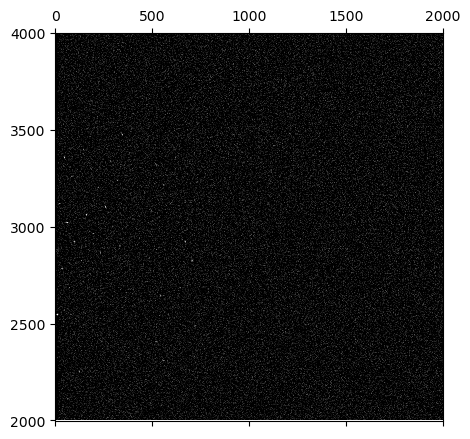

In [69]:
# Plot the points found on the first pass (thresholding with num_sd)

log_diff_spectrum_s = sfft.fftshift(peaky_smooth, axes=0)
unwrapped_indices = sax.unwrap_indices(np.array([masked_index_y, masked_index_x]), power)
unwrapped_indices[0,:] = unwrapped_indices[0,:] + np.shape(power)[0]/2

plt.matshow(log_diff_spectrum_s,
           cmap = "Greys_r",
           vmax = 4,
           vmin = 0)

#lt.scatter(x = unwrapped_indices[1,:], y = unwrapped_indices[0,:], s = 1, alpha = 1)

plt.xlim(0,2000)
plt.ylim(2000,4000)
